# Example 10 A: Inverted Pendulum with Wall

In [1]:
import numpy as np
import scipy.linalg as spa
import pypolycontain as pp
import pydrake.solvers.mathematicalprogram as MP
import pydrake.solvers.gurobi as Gurobi_drake
# use Gurobi solver
global gurobi_solver, license
gurobi_solver=Gurobi_drake.GurobiSolver()
license = gurobi_solver.AcquireLicense()

import pypolycontain as pp
import pypolycontain.pwa_control as pwa

import matplotlib.pyplot as plt

## Dynamcis and matrices
The system is constrained to $|\theta| \le 0.12$, $|\dot{\theta}| \le 1$, $|u| \le 4$, and the wall is situated at $\theta=0.1$. The problem is to identify a set of states $\mathcal{X} \in \mathbb{R}^2$ and the associated control law $\mu: [-0.12,0.12] \times [-1,1] \rightarrow [-4,4]$ such that all states in $\mathcal{X}$ are steered toward origin in finite time, while respecting the constraints. It is desired that $\mathcal{X}$ is as large as possible. The dynamical system is described as a hybrid system with two modes associated with ``contact-free" and ``contact". The piecewise affine dynamics is given as:
\begin{equation*}
A_1=
\left(
\begin{array}{cc}
1 & 0.01 \\
0.1 & 1
\end{array}
\right),
A_2=
\left(
\begin{array}{cc}
1 & 0.01 \\
-9.9 & 1
\end{array}
\right),
\end{equation*} 
\begin{equation*}
B_1=B_2=
\left(
\begin{array}{c}
0 \\ 0.01
\end{array}
\right),
c_1=
\left(
\begin{array}{c}
0 \\ 0 
\end{array}
\right) ,
c_2=
\left(
\begin{array}{c}
0 \\ 1
\end{array}
\right),
\end{equation*} 
where mode 1 and 2 correspond to contact-free $\theta \le 0.1$ and contact dynamics $\theta >0.1$, respectively.  

In [2]:
A=np.array([[1,0.01],[0.1,1]])
B=np.array([0,0.01]).reshape(2,1)
c=np.array([0,0]).reshape(2,1)
C=pp.unitbox(N=3).H_polytope
C.h=np.array([0.1,1,4,0.1,1,4]).reshape(6,1)
S1=pwa.affine_system(A,B,c,name='free',XU=C)

# X=pp.zonotope(G=np.array([[0.1,0],[0,1]]))
# U=pp.zonotope(G=np.ones((1,1))*4)
# W=pp.zonotope(G=np.array([[0.1,0],[0,1]]))
# Omega=rci_old(A, B, X, U , W, q=5,eta=0.001)

import pickle
(H,h)=pickle.load(open('example_inverted_pendulum_H.pkl','rb'))
Omega=pp.H_polytope(H, h)


A=np.array([[1,0.01],[-9.9,1]])
B=np.array([0,0.01]).reshape(2,1)
c=np.array([0,1]).reshape(2,1)
C=pp.unitbox(N=3).H_polytope
C.h=np.array([0.12,1,4,-0.1,1,4]).reshape(6,1)
S2=pwa.affine_system(A,B,c,name='contact',XU=C)


myS=pwa.pwa_system()   
myS.add_mode(S1)
myS.add_mode(S2)

## A Polytopic Trajectory 

In [3]:
T=50
goal=0.0001*pp.unitbox(2).H_polytope
x0=np.array([0,0.75]).reshape(2,1)
F,FH,_,_,_=pwa.extend(myS,x0,T,[goal],H_rep=False,color='blue')

disjunctive subset with 1 circumbodies
**********  Set up a mixed-integer optimization problem **********
polytopic trajectory optimization succesfull


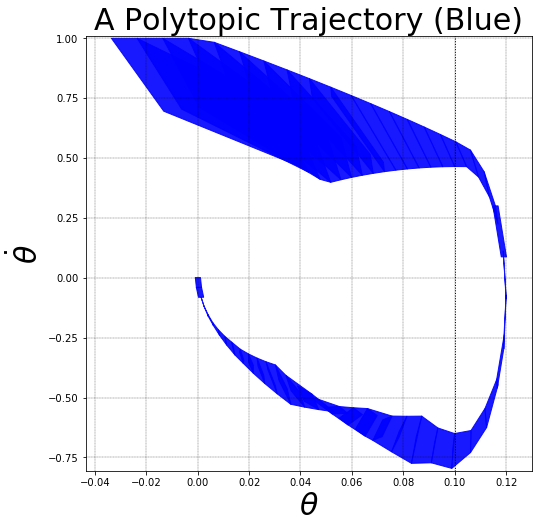

In [4]:
fig,ax=plt.subplots()
pp.visualize(F,fig=fig,ax=ax,a=0.01,alpha=0.9)   
ax.set_xlabel(r'$\theta$',FontSize=30)
ax.set_ylabel(r'$\dot{\theta}$',FontSize=30)
ax.set_title('A Polytopic Trajectory (Blue)',FontSize=30)
ax.axvline(x=0.1,LineWidth=1,linestyle=':',color='black')

# My first branch: connect polytopic trajectories

disjunctive subset with 50 circumbodies
**********  Set up a mixed-integer optimization problem **********
polytopic trajectory optimization succesfull


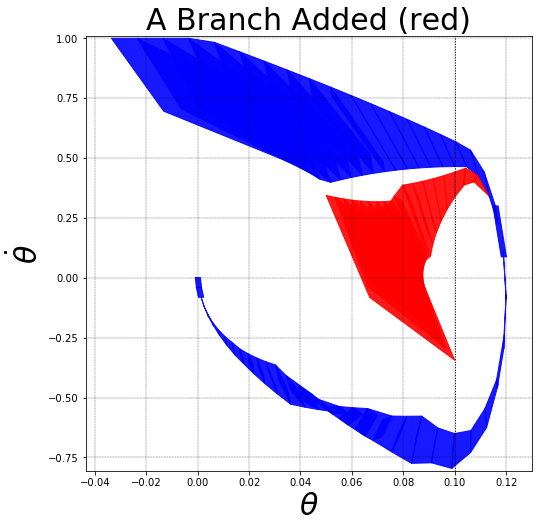

In [5]:
T=18
x0=np.array([0.075,0]).reshape(2,1)
F2,_,_,_,_=pwa.extend(myS,x0,T,F,H_rep=False,color='red')
fig,ax=plt.subplots()
pp.visualize(F+F2,fig=fig,ax=ax,a=0.01,alpha=0.9)   
ax.set_xlabel(r'$\theta$',FontSize=30)
ax.set_ylabel(r'$\dot{\theta}$',FontSize=30)
ax.set_title('A Branch Added (red)',FontSize=30)
ax.axvline(x=0.1,LineWidth=1,linestyle=':',color='black')

## Building A Tree

In [6]:
def sampler():
    L=np.array([0.12,1])
    return np.random.uniform(-L,L).reshape(2,1)
    
T=10
list_of_H_polytopes=[Omega]
list_of_nodes=[Omega]
stop_sampling=False
sample=lambda :sampler()
branch=0
trajectory={}
i=0
while branch<30 and i<500:
    i+=1
    print("i:",i, "branch:", branch)
    while not stop_sampling:
        x0=sample()
        flag=pwa.in_the_tree(x0,list_of_H_polytopes)
        stop_sampling=not flag
    try:
        print("sample:",x0.T)
        x,u,mu=pwa.point_trajectory(myS,x0,T=60,goal=Omega,Q=np.eye(2)*1)
        Y,YY,xx,mumu,G=pwa.extend(myS,x0,T,list_of_nodes)
        trajectory[branch]=(x,u,mu,xx,mumu,G)
        # Y,YY=extend(x0,T,[Omega])
        list_of_nodes.extend(Y)
        list_of_H_polytopes.extend(YY)
        branch+=1
    except:
        print('failed to extend')
    stop_sampling=False

i: 1 branch: 0
sample: [[ 0.10542656 -0.55298934]]
trajectory optimization succesfull
contact mode change detected
disjunctive subset with 1 circumbodies
**********  Set up a mixed-integer optimization problem **********
polytopic trajectory optimization succesfull
i: 2 branch: 1
sample: [[ 0.10888614 -0.30973276]]
trajectory optimization succesfull
contact mode change detected
disjunctive subset with 11 circumbodies
**********  Set up a mixed-integer optimization problem **********
polytopic trajectory optimization succesfull
i: 3 branch: 2
sample: [[0.04962442 0.8912329 ]]
trajectory optimization failed
failed to extend
i: 4 branch: 2
sample: [[0.11944372 0.46074421]]
trajectory optimization failed
failed to extend
i: 5 branch: 2
sample: [[0.11556939 0.30248857]]
trajectory optimization succesfull
contact mode change detected
disjunctive subset with 21 circumbodies
**********  Set up a mixed-integer optimization problem **********
polytopic trajectory optimization succesfull
i: 6 bra

## Visualization

/usr/lib/python3/dist-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


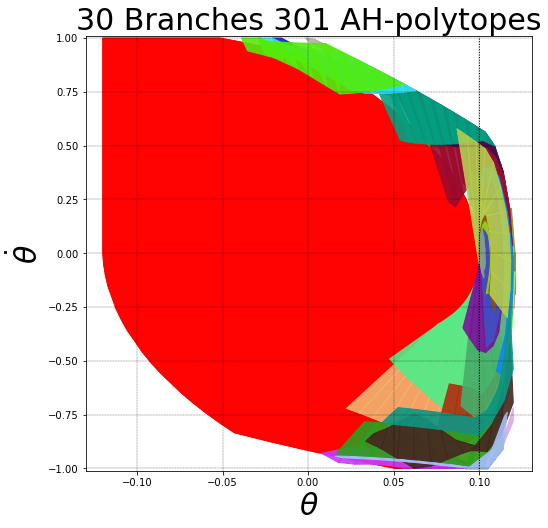

In [7]:
fig,ax=plt.subplots()
pp.visualize([Omega]+list_of_nodes,fig=fig,ax=ax,a=0.01,alpha=0.9)   
ax.set_xlabel(r'$\theta$',FontSize=30)
ax.set_ylabel(r'$\dot{\theta}$',FontSize=30)
ax.set_title('%d Branches %d AH-polytopes'%(branch,len(list_of_nodes)),FontSize=30)
ax.axvline(x=0.1,LineWidth=1,linestyle=':',color='black')

### Studying Coverage
We generate random points and see 

In [9]:
Trials=200
covered=0
false_positive=0
feasible=0
feasible_but_not_covered_by_N_10=0
for N in range(Trials):
    x0=sample()
    print(N)
    try:
        _,_,_=pwa.point_trajectory(myS,x0,T=50,goal=Omega,Q=np.eye(2)*100)
        feasible+=1        
        covered+=pwa.in_the_tree(x0,list_of_H_polytopes)
        try:
            _,_,_=pwa.point_trajectory(myS,x0,T=10,goal=Omega,Q=np.eye(2)*100)
        except:
            feasible_but_not_covered_by_N_10+=1
    except:
        false_positive+=pwa.in_the_tree(x0,list_of_H_polytopes)

0
trajectory optimization succesfull
trajectory optimization succesfull
1
trajectory optimization failed
2
trajectory optimization failed
3
trajectory optimization succesfull
trajectory optimization succesfull
4
trajectory optimization failed
5
trajectory optimization succesfull
trajectory optimization succesfull
6
trajectory optimization succesfull
contact mode change detected
trajectory optimization succesfull
7
trajectory optimization succesfull
trajectory optimization succesfull
8
trajectory optimization succesfull
trajectory optimization succesfull
9
trajectory optimization succesfull
trajectory optimization succesfull
10
trajectory optimization succesfull
trajectory optimization succesfull
11
trajectory optimization succesfull
trajectory optimization succesfull
12
trajectory optimization failed
13
trajectory optimization failed
14
trajectory optimization succesfull
trajectory optimization succesfull
15
trajectory optimization failed
16
trajectory optimization succesfull
trajector

In [10]:
print("feasible: %d    covered: %d"%(feasible,covered)) 
print("covered by N=10: %d"%(feasible - feasible_but_not_covered_by_N_10)) 
print("infeasible: %d    false positive because of H-rep over-approximation: %d"%(Trials-feasible,false_positive)) 

feasible: 142    covered: 142
covered by N=10: 132
infeasible: 58    false positive because of H-rep over-approximation: 25
